# Assessing GDPR-Compliance in Web Applications: A Machine Learning Approach

We will assess the GDPR-compliance of web applications based on their privacy policies. We use a classification model, trained on a corpus of 18,397 natural sentences, to classify the privacy policies on whether five General Data Protection Regulation (GDPR) privacy policy core requirements are communicated in the policy.

__Relevance:__ The GDPR applies to any personal data processing of EU citizens. We aim to assess the state of GDPR-compliance in application software based on their privacy policies.

__Focus:__ web applications; as the web application paradigm is widely used due to the omnipresence of web browsers across PCs and mobile devices. In particular, we focus on organisations that provide cloud-based solutions: ___Cloud Computing, Cloud Data Services, Cloud Infrastructure, Cloud, Management, and Cloud Storage.___


__Goal:__ to scrutinize the privacy policies of web applications using ML, to assess whether core privacy policy requirements are communicated.

#### __RQ:__ What is the state of GDPR-compliance disclosure in web applications?
---

Collected 4222 companies with privacy policies

---

In [1]:
import os
from newspaper import Article
from bs4 import BeautifulSoup
from six.moves.urllib.parse import urlparse
import urllib
import sys
import time
import nltk
import glob
import pandas as pd
import requests
import spacy
import random
# from googlesearch import search
from langdetect import detect
import re
import pickle
import math
import numpy as np
import collections
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from tabulate import tabulate
from IPython.display import display, HTML

---
### Intermezzo: select 50 companies from initial list from Crunchbase and validate

In [130]:
path = r'C:\Users\aaberkan\OneDrive - UGent\Scripts\GDPR-Compliance in Web Applications\data\Crunchbase\Cloud'
filenames = glob.glob(path + "/*.csv")

In [131]:
len(filenames)

30

In [132]:
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

In [133]:
crunch_data = pd.concat(dfs, ignore_index=True)

In [139]:
crunch_data.sample(n = 50, random_state = 33)

,Organization Name,Organization Name URL,Full Description,Industries,Website,Headquarters Location,Description,CB Rank (Company),SEMrush - Monthly Visits,SEMrush - Average Visits (6 months),...,Founded Date,Founded Date Precision,Number of Founders,Number of Employees,Founders,Apptopia - Number of Apps,Apptopia - Downloads Last 30 Days,Aberdeen - IT Spend,Aberdeen - IT Spend Currency,Aberdeen - IT Spend Currency (in USD)
4261,Trinetica,https://www.crunchbase.com/organization/trinetica,NaN,"Cloud Computing, Consulting, Information Techn...",http://trinetica.com/,"Fort Wayne, Indiana, United States",Trinetica is an IT company specializing in sof...,"1,840,848",NaN,NaN,...,2011-01-01,year,NaN,11-50,NaN,NaN,NaN,NaN,NaN,NaN
2895,Cloudant,https://www.crunchbase.com/organization/cloudant,Cloudant’s distributed database-as-a-service (...,"Big Data, Cloud Computing, Enterprise Software...",https://www.ibm.com/,"Boston, Massachusetts, United States",Cloudant provides a distributed database-as-a-...,"61,223",NaN,NaN,...,2008-01-01,year,3.0,51-100,"Adam Kocoloski, Alan Hoffman, Michael Miller",NaN,NaN,NaN,NaN,NaN
938,ASAP,https://www.crunchbase.com/organization/asap-fa1a,NaN,"Cloud Computing, Information Technology, Software",https://asapbts.com,"Saint Louis, Missouri, United States","ASAP provides managed IT, communication, secur...","1,346,968","2,386",NaN,...,2004-01-01,year,NaN,11-50,NaN,NaN,NaN,NaN,NaN,NaN
19774,Maus Software,https://www.crunchbase.com/organization/maus-s...,NaN,"Accounting, Business Intelligence, Cloud Manag...",https://maus.com/,"Tampa, Florida, United States","Maus Software provides accountants, bookkeeper...","445,693","2,856","30,406.5",...,1992-01-01,year,NaN,11-50,NaN,NaN,NaN,NaN,NaN,NaN
5384,Flexe,https://www.crunchbase.com/organization/flexe,Flexe delivers omnichannel logistics programs ...,"Cloud Computing, E-Commerce, Logistics, Supply...",https://www.flexe.com,"Seattle, Washington, United States",Flexe delivers omnichannel logistics programs ...,"1,626","20,362","17,098.33",...,2013-01-01,year,3.0,251-500,"Edmond Yue, Francis Duong, Karl Siebrecht",NaN,NaN,NaN,NaN,NaN
12616,Virnex,https://www.crunchbase.com/organization/virnex,NaN,"Cloud Data Services, Consulting, IT Management...",https://virnex.fi/,"Lahti, Southern Finland, Finland",Virnex is an IT consulting firm that offers cl...,"997,173","1,104",NaN,...,2019-01-01,year,NaN,51-100,NaN,NaN,NaN,NaN,NaN,NaN
10349,A7 TECHNOLOGY BUSINESS AND SERVICE LTDA,https://www.crunchbase.com/organization/a7-tec...,NaN,"Cloud Computing, Information Technology, Softw...",https://a7technology.com,"Bainbridge Island, Washington, United States",A7 TECHNOLOGY BUSINESS AND SERVICE LTDA offers...,"469,833",NaN,NaN,...,2002-01-01,year,NaN,11-50,NaN,NaN,NaN,NaN,NaN,NaN
2410,Azon5,https://www.crunchbase.com/organization/azon5,Azon5 provides their clients with software pro...,"Business Development, Cloud Computing, Consult...",https://azon5.com,"Lviv, L'vivs'ka Oblast', Ukraine",Azon5 provides software development for busine...,"1,647,800",NaN,NaN,...,2010-01-01,year,NaN,11-50,NaN,NaN,NaN,NaN,NaN,NaN
20172,Performix Technologies,https://www.crunchbase.com/organization/perfor...,Performix Technologies is a provider of employ...,"Cloud Management, Enterprise Software, Real Ti...",http://www.performixtechnologies.com/,"Burlington, Massachusetts, United States",Performix Technologies is a provider of employ...,"446,017",NaN,NaN,...,1998-01-01,year,NaN,101-250,NaN,NaN,NaN,NaN,NaN,NaN
7818,Talk Think Do,https://www.crunchbase.com/organization/talk-t...,NaN,"Architecture, Cloud Computing, Digital Signage",http://talkthinkdo.co.uk,"Wimborne, Dorset, United Kingdom",Talk think do is a digital agency that deals w...,"955,986",NaN,NaN,...,2014-01-01,day,NaN,1-10,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
crunch_data.sample(n = 50, random_state = 42).to_csv("crunch_valid.csv", sep='\t', header=True, index=False)

##### Sample 1: 50 companies
- 12 services
- 12 website
- 26 no privacy policy, or ambiguous applicability

In [140]:
crunch_data.sample(n = 50, random_state = 33).to_csv("crunch_valid2.csv", sep='\t', header=True, index=False)

##### Sample 2: 50 companies
- 10 services
- 5 website
- 35 no privacy policy, or ambiguous applicability

---

#### Read classified data

In [2]:
# crunch_data_r_selected.to_csv("crunch_classified_p1.csv", sep='\t', header=True, index=False)
crunch_classified_p1 = pd.read_csv("crunch_classified_p1.csv", sep='\t', encoding='utf-8')
crunch_classified_p2 = pd.read_csv("crunch_classified_p2.csv", sep='\t', encoding='utf-8')
# crunch_classified_p3 = pd.read_csv("crunch_classified_p3.csv", sep='\t', encoding='utf-8')

In [5]:
crunch_classified = crunch_classified_p1.append(crunch_classified_p2)
crunch_classified

,Organization Name,Organization Name URL,Full Description,Industries,Website,Headquarters Location,Description,CB Rank (Company),SEMrush - Monthly Visits,SEMrush - Average Visits (6 months),...,Aberdeen - IT Spend,Aberdeen - IT Spend Currency,Aberdeen - IT Spend Currency (in USD),PP URL,DPO,Purpose,Acquired data,Data sharing,Rights,PP text
0,Exact,https://www.crunchbase.com/organization/exact,Exact is a global supplier of cloud business s...,"Accounting, Cloud Computing, CRM, Enterprise R...",http://www.exact.com,"Delft, Zuid-Holland, The Netherlands",Exact is a company that provides cloud based b...,"229,780","622,387","672,910.5",...,NaN,NaN,NaN,https://www.exact.com/privacy-statement,1,1,0,1,1,['exact hold BV a compani regist in the nether...
1,Xperience,https://www.crunchbase.com/organization/xperie...,Xperience provides software solutions within E...,"Cloud Computing, Consulting, CRM, Enterprise R...",https://www.xperience-group.com/,"Antrim, Antrim, United Kingdom",Xperience provides software solutions within E...,"187,002","402,949","198,967.83",...,6256711.0,USD,6256711.0,https://www.xperience-group.com/site-pages/pri...,1,1,1,1,1,['thi privaci statement is effect as of januar...
2,CRS4,https://www.crunchbase.com/organization/crs4,"Established in 1990, CRS4 (Center for Advanced...","Business Development, Cloud Computing, Educati...",http://www.crs4.it/,"Pula, Sardegna, Italy",CRS4 is an interdisciplinary research center p...,"764,573","103,411","58,347.33",...,NaN,NaN,NaN,https://www.crs4.it/privacy-policy/,1,0,0,0,1,['notic regard the process OF person data of u...
3,Siav,https://www.crunchbase.com/organization/siav,NaN,"Cloud Computing, Information Technology, Software",https://www.siav.com,"Rubano, Veneto, Italy","Siav provides digital storage, document manage...","524,480","40,997","17,044.83",...,3849039.0,USD,3849039.0,https://www.siav.com/privacy-policy/,1,1,0,0,1,"['', 'purpos of the process of person data art..."
4,Olivetti,https://www.crunchbase.com/organization/olivetti,Olivetti provides information technology produ...,"Cloud Computing, Cloud Data Services, Computer...",http://www.olivetti.com/,"Ivrea, Piemonte, Italy",Olivetti provides information technology produ...,"265,011","17,219","36,368.67",...,NaN,NaN,NaN,https://www.olivetti.com/en/web-privacy-policy...,1,0,0,0,1,['the purpos of thi privaci polici is to descr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,Test Triangle Ltd,https://www.crunchbase.com/organization/test-t...,NaN,"Cloud Infrastructure, Consulting, Penetration ...",http://www.testtriangle.com,"Dublin, Dublin, Ireland",'The as-a-Service Company - helping ship bette...,"520,236","3,375",NaN,...,NaN,NaN,NaN,https://www.testtriangle.com/data-privacy-stat...,1,0,1,1,1,"['privaci statement', 'ani chang to thi websit..."
2472,Elliot Cloud,https://www.crunchbase.com/organization/elliot...,Elliot Cloud provides control and management o...,"Cloud Infrastructure, Cloud Management, Infras...",https://elliotcloud.com,"Madrid, Madrid, Spain",Elliot Cloud provides solutions for smart wate...,"1,094,809","3,278",NaN,...,NaN,NaN,NaN,https://elliotcloud.com/en/privacy-policy/,1,0,1,0,1,"['I privaci polici', 'In complianc with regul ..."
2473,Syndicai,https://www.crunchbase.com/organization/syndicai,Syndicai provides a cloud platform for AI mode...,"Artificial Intelligence, Cloud Infrastructure,...",https://syndicai.co/,"Kraków, Malopolskie, Poland",Your AI model ready for production in a few si...,"276,638","3,203","3,270",...,NaN,NaN,NaN,https://www.syndicai.co/legal/privacy-policy,1,0,0,1,1,"['gener inform', 'thi privaci polici contain g..."
2474,DediServe,https://www.crunchbase.com/organization/dediserve,Dediserve was founded with the passionate beli...,"Cloud Infrastructure, IaaS, Information Techno...",http://www.dediserve.com,"Dublin, Dublin, Ireland",DediServe is an SSD-backed cloud platform that...,"360,628","2,857","6,976.17",...,NaN,NaN,NaN,https

In [7]:
GDPR_classes = ['DPO', 'Purpose', 'Acquired data', 'Data sharing', 'Rights']

In [129]:
for idx, GDPR_class in enumerate(GDPR_classes):  
    pos_ratio = ((crunch_classified[GDPR_class].value_counts()[1]/crunch_classified.shape[0])*100)
    neg_ratio = ((crunch_classified[GDPR_class].value_counts()[0]/crunch_classified.shape[0])*100)
    
    classification_analysis = [
       [GDPR_class, crunch_classified.shape[0], str(crunch_classified[GDPR_class].value_counts()[1]) + " (%.2f%%)" % pos_ratio, 
        str(crunch_classified[GDPR_class].value_counts()[0]) + " (%.2f%%)" % neg_ratio],
      ]
    
    classification_analysis = pd.DataFrame(classification_analysis, columns =['GDPR Class', '# companies', 'Postive', 'Negative'])
#     print(summary_sm_sk.to_markdown())
    
    display(HTML(classification_analysis.to_html(index=False)))
    print()
    
# get length of df where all classes are classified as 1
len_all_1 = len(crunch_classified[(crunch_classified["DPO"] == 1) & (crunch_classified["Purpose"] == 1) & (crunch_classified["Acquired data"] == 1)
                  & (crunch_classified["Data sharing"] == 1) & (crunch_classified["Rights"] == 1)])

pos_ratio = ((len_all_1/crunch_classified.shape[0])*100)
neg_ratio = 100 - pos_ratio

classification_analysis = [
   ["All classes", crunch_classified.shape[0], str(len_all_1)  + " (%.2f%%)" % pos_ratio, 
    str(crunch_classified.shape[0]-len_all_1)  + " (%.2f%%)" % neg_ratio],
#        [GDPR_labels[idx], 'L1', 'numerical', 'full data', sm_lr_numpredictors_acc[idx], {k:v for (k,v) in dict(sm_lr_numpredictors[idx].pvalues).items() if ((v <= 0.05) and ( v != 0) and (k != 'const'))}]
  ]
classification_analysis = pd.DataFrame(classification_analysis, columns =['GDPR Class', '# companies', 'Postive', 'Negative'])
#     print(summary_sm_sk.to_markdown())

display(HTML(classification_analysis.to_html(index=False)))

GDPR Class,# companies,Postive,Negative
DPO,4222,3276 (77.59%),946 (22.41%)


GDPR Class,# companies,Postive,Negative
Purpose,4222,3111 (73.69%),1111 (26.31%)


GDPR Class,# companies,Postive,Negative
Acquired data,4222,3399 (80.51%),823 (19.49%)


GDPR Class,# companies,Postive,Negative
Data sharing,4222,3228 (76.46%),994 (23.54%)


GDPR Class,# companies,Postive,Negative
Rights,4222,2660 (63.00%),1562 (37.00%)


GDPR Class,# companies,Postive,Negative
All classes,4222,1731 (41.00%),2491 (59.00%)


# Some More Analysis

In [41]:
# pd_stats = crunch_data_r_selected[["Employees", "Founded Date", "Location", "Industry 1", "DPO", "Purpose", "Acquired data", "Data sharing", "Rights"]].copy(deep=True)
pd_stats = crunch_classified.copy(deep=True)

In [42]:
pd_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4222 entries, 0 to 2475
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Organization Name                      4222 non-null   object 
 1   Organization Name URL                  4222 non-null   object 
 2   Full Description                       2697 non-null   object 
 3   Industries                             4222 non-null   object 
 4   Website                                4222 non-null   object 
 5   Headquarters Location                  4222 non-null   object 
 6   Description                            4222 non-null   object 
 7   CB Rank (Company)                      4218 non-null   object 
 8   SEMrush - Monthly Visits               2602 non-null   object 
 9   SEMrush - Average Visits (6 months)    1805 non-null   object 
 10  SEMrush - Monthly Visits Growth        2224 non-null   object 
 11  SEMr

##### Employees

In [43]:
pd_stats["Number of Employees"].value_counts()

11-50         1752
1-10          1138
101-250        437
51-100         405
251-500        190
501-1000       111
1001-5000       85
5001-10000      15
10001+          13
Name: Number of Employees, dtype: int64

##### Founded Date

In [44]:
pd_stats["Founded Date"].value_counts()

2012-01-01    215
2014-01-01    205
2015-01-01    189
2016-01-01    182
2013-01-01    176
             ... 
2011-01-13      1
1995-06-28      1
2014-03-17      1
1999-11-01      1
1999-03-05      1
Name: Founded Date, Length: 689, dtype: int64

Convert to year

In [45]:
f_date = pd_stats["Founded Date"].tolist()

In [46]:
f_date_clean = [re.findall(r'(\d{4})', date)[0] if date is not np.nan else (np.nan) for date in f_date]

In [47]:
len(f_date)

4222

In [48]:
(f_date_clean)

['1984',
 '1969',
 '1990',
 '1990',
 '1908',
 '1971',
 '1983',
 '1990',
 '1967',
 '1988',
 '1984',
 '1989',
 '1990',
 '1972',
 '1982',
 '1939',
 '1984',
 '1990',
 '1979',
 '1970',
 '1972',
 '1988',
 '1987',
 '1981',
 '1989',
 '1982',
 '1987',
 '1987',
 '1935',
 '1972',
 '1985',
 '1990',
 '1977',
 '1983',
 '1989',
 '1971',
 '1985',
 '1988',
 '1775',
 '1994',
 '1993',
 '1980',
 '1985',
 '1992',
 '1987',
 '1993',
 '1990',
 '1994',
 '1995',
 '1979',
 '1985',
 '1932',
 '1985',
 '1986',
 '1981',
 '1978',
 '1987',
 '1995',
 '1994',
 '1985',
 '1990',
 '1981',
 '1991',
 '1994',
 '1974',
 '1991',
 '1976',
 '1972',
 '1995',
 '1993',
 '1989',
 '1982',
 '1993',
 '1989',
 '1989',
 '1995',
 '1993',
 '1990',
 '1992',
 '1995',
 '1979',
 '1995',
 '1993',
 '1994',
 '1986',
 '1991',
 '1994',
 '1984',
 '1979',
 '1981',
 '1992',
 '1994',
 '1958',
 '1948',
 '1972',
 '1989',
 '1985',
 '1982',
 '1989',
 '1992',
 '1992',
 '1995',
 '1993',
 '1988',
 '1988',
 '1984',
 '1995',
 '1989',
 '1992',
 '1990',
 '1985',
 

In [49]:
pd_stats["Founded Year"] = f_date_clean

In [51]:
pd_stats["Founded Year"].value_counts()

2012    300
2014    298
2015    282
2016    260
2013    258
       ... 
1948      1
1945      1
1966      1
1935      1
1932      1
Name: Founded Year, Length: 75, dtype: int64

<AxesSubplot:xlabel='Founded Year'>

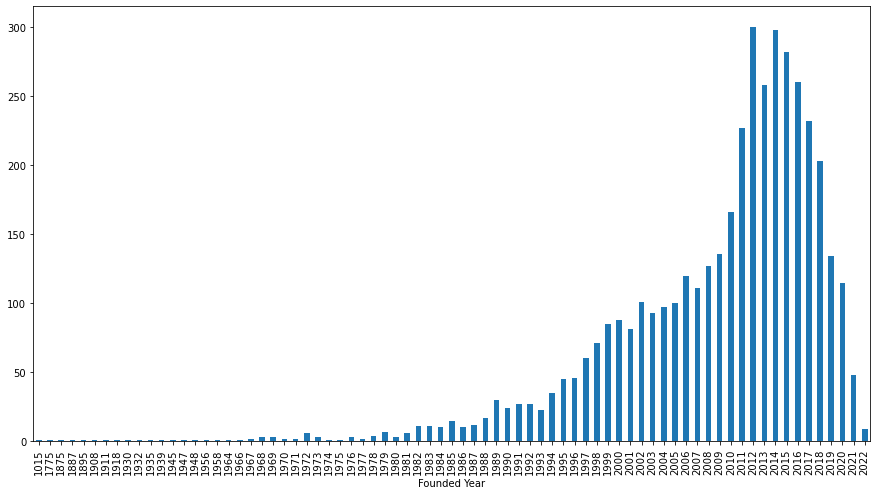

In [60]:
pd_stats["Founded Year"].groupby(pd_stats["Founded Year"]).count().plot(kind="bar", figsize=(15,8))

In [76]:
pd_stats[pd_stats["Founded Year"] == "1939"]
# https://www.georgehay.co.uk/about-us; klopt

,Organization Name,Organization Name URL,Full Description,Industries,Website,Headquarters Location,Description,CB Rank (Company),SEMrush - Monthly Visits,SEMrush - Average Visits (6 months),...,Aberdeen - IT Spend Currency,Aberdeen - IT Spend Currency (in USD),PP URL,DPO,Purpose,Acquired data,Data sharing,Rights,PP text,Founded Year
15,George Hay Chartered Accountants,https://www.crunchbase.com/organization/george...,George Hay Chartered Accountants are professio...,"Accounting, Cloud Computing, Financial Services",https://www.georgehay.co.uk,"Biggleswade, Bedfordshire, United Kingdom",George Hay Chartered Accountants provides acco...,"1,514,957",785,NaN,...,USD,31979999.0,https://www.georgehay.co.uk/privacy-policy,1,1,1,1,1,"['what doe thi privaci polici cover', 'thi pol...",1939


In [143]:
pd_stats[pd_stats["Founded Year"] == "1775"]

,Organization Name,Organization Name URL,Full Description,Industries,Website,Headquarters Location,Description,CB Rank (Company),SEMrush - Monthly Visits,SEMrush - Average Visits (6 months),...,Aberdeen - IT Spend Currency (in USD),PP URL,DPO,Purpose,Acquired data,Data sharing,Rights,PP text,Founded Year,Country
38,United States Navy,https://www.crunchbase.com/organization/us-navy,"The U.S. Navy was founded on 13 October 1775, ...","Big Data, Cloud Computing, Cyber Security, Hea...",http://www.navy.mil/,"Arlington, Virginia, United States","We are the United States Navy, our Nation's se...","186,147","5,843,776","5,423,852.83",...,NaN,https://www.navy.mil/privacy,1,1,1,1,0,['unit state navi is commit to protect your pr...,1775,United States


##### Location          

In [77]:
pd_stats["Headquarters Location"].value_counts()

London, England, United Kingdom             238
San Francisco, California, United States    177
New York, New York, United States           140
Seattle, Washington, United States           50
Austin, Texas, United States                 48
                                           ... 
Westwood, Massachusetts, United States        1
Finland, Minnesota, United States             1
Kildare, Kildare, Ireland                     1
Mytholmroyd, York, United Kingdom             1
Maarssen, Utrecht, The Netherlands            1
Name: Headquarters Location, Length: 1302, dtype: int64

In [78]:
location = pd_stats["Headquarters Location"].to_list()

In [79]:
country = [(country.split(", ")[-1]) for country in location]

In [81]:
pd_stats["Country"] = country

In [82]:
# Jersey klopt waarschijnlijk niet
pd_stats["Country"].value_counts()

United States                 2573
United Kingdom                 682
India                          191
Germany                        132
France                          68
The Netherlands                 65
Spain                           49
Ireland                         47
Sweden                          45
Switzerland                     44
Belgium                         37
Finland                         28
Norway                          25
Italy                           25
Poland                          24
Denmark                         24
Estonia                         19
Romania                         15
Ukraine                         13
Turkey                          11
Austria                         11
Portugal                        11
Lithuania                       10
Greece                           9
Czech Republic                   9
Cyprus                           9
Croatia                          9
Luxembourg                       7
Bulgaria            

<AxesSubplot:>

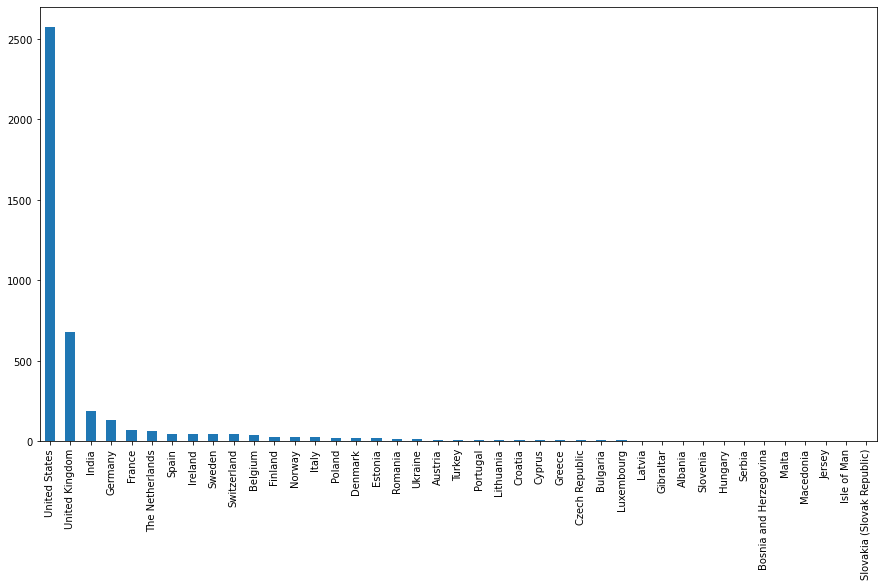

In [91]:
pd_stats["Country"].sort_values().value_counts().plot(kind="bar", figsize=(15,8))

In [ ]:
pd_stats.loc[pd_stats['Country'] != "United States"]["DPO"].value_counts().plot.pie(y='x_value', colors=['blue', 'red'], autopct='%1.1f%%')

#### Explore USA, India, EU

In [128]:
for idx, GDPR_class in enumerate(GDPR_classes):  
    pos_ratio = ((crunch_classified[GDPR_class].value_counts()[1]/crunch_classified.shape[0])*100)
    neg_ratio = ((crunch_classified[GDPR_class].value_counts()[0]/crunch_classified.shape[0])*100)
    print(GDPR_class)
    
    counts_usa = crunch_classified.loc[pd_stats['Country'] == "United States"][GDPR_class].value_counts()
    pos_ratio_usa = ((counts_usa[1]/crunch_classified.loc[pd_stats['Country'] == "United States"].shape[0])*100)
#     print(counts_usa[1])
    counts_india = crunch_classified.loc[pd_stats['Country'] == "India"][GDPR_class].value_counts()
    pos_ratio_india = ((counts_india[1]/crunch_classified.loc[pd_stats['Country'] == "India"].shape[0])*100)
    counts_eu = crunch_classified.loc[(pd_stats['Country'] != "United States") & (pd_stats['Country'] != "India")][GDPR_class].value_counts()
    pos_ratio_eu = ((counts_eu[1]/crunch_classified.loc[(pd_stats['Country'] != "United States") & (pd_stats['Country'] != "India")][GDPR_class].shape[0])*100)
    
    classification_analysis = [
       ["All", crunch_classified.shape[0], str(crunch_classified[GDPR_class].value_counts()[1]) + " (%.2f%%)" % pos_ratio, 
        str(crunch_classified[GDPR_class].value_counts()[0]) + " (%.2f%%)" % neg_ratio],
        ["USA", crunch_classified.loc[pd_stats['Country'] == "United States"].shape[0], str(counts_usa[1]) + " (%.2f%%)" % pos_ratio_usa, 
        str(counts_usa[0]) + " (%.2f%%)" % (100-pos_ratio_usa)],
        ["India", crunch_classified.loc[pd_stats['Country'] == "India"].shape[0], str(counts_india[1]) + " (%.2f%%)" % pos_ratio_india, 
        str(counts_india[0]) + " (%.2f%%)" % (100-pos_ratio_india)],
        ["Europe", crunch_classified.loc[(pd_stats['Country'] != "United States") & (pd_stats['Country'] != "India")][GDPR_class].shape[0], str(counts_eu[1]) + " (%.2f%%)" % pos_ratio_eu, 
        str(counts_eu[0]) + " (%.2f%%)" % (100-pos_ratio_eu)]
      ]
    
    classification_analysis = pd.DataFrame(classification_analysis, columns =['Country', '# companies', 'Postive', 'Negative'])
#     print(summary_sm_sk.to_markdown())
    
    display(HTML(classification_analysis.to_html(index=False)))
    print()
    
# get length of df where all classes are classified as 1
len_all_1 = len(crunch_classified[(crunch_classified["DPO"] == 1) & (crunch_classified["Purpose"] == 1) & (crunch_classified["Acquired data"] == 1)
                  & (crunch_classified["Data sharing"] == 1) & (crunch_classified["Rights"] == 1)])
len_all_1_usa = len(crunch_classified[(crunch_classified["DPO"] == 1) & (crunch_classified["Purpose"] == 1) & (crunch_classified["Acquired data"] == 1)
                  & (crunch_classified["Data sharing"] == 1) & (crunch_classified["Rights"] == 1) 
                  & (pd_stats['Country'] == "United States")])
len_all_1_india = len(crunch_classified[(crunch_classified["DPO"] == 1) & (crunch_classified["Purpose"] == 1) & (crunch_classified["Acquired data"] == 1)
                  & (crunch_classified["Data sharing"] == 1) & (crunch_classified["Rights"] == 1) 
                  & (pd_stats['Country'] == "India")])
len_all_1_eu = len(crunch_classified[(crunch_classified["DPO"] == 1) & (crunch_classified["Purpose"] == 1) & (crunch_classified["Acquired data"] == 1)
                  & (crunch_classified["Data sharing"] == 1) & (crunch_classified["Rights"] == 1) 
                  & (pd_stats['Country'] != "United States") & (pd_stats['Country'] != "India")])
pos_ratio = ((len_all_1/crunch_classified.shape[0])*100)
pos_ratio_usa = ((len_all_1_usa/crunch_classified.loc[pd_stats['Country'] == "United States"].shape[0])*100)
pos_ratio_india = ((len_all_1_india/crunch_classified.loc[pd_stats['Country'] == "India"].shape[0])*100)
pos_ratio_eu = ((len_all_1_eu/crunch_classified.loc[(pd_stats['Country'] != "United States") & (pd_stats['Country'] != "India")][GDPR_class].shape[0])*100)

print("All classes")
classification_analysis = [
   ["All", crunch_classified.shape[0], str(len_all_1)  + " (%.2f%%)" % pos_ratio, 
    str(crunch_classified.shape[0]-len_all_1)  + " (%.2f%%)" % (100-pos_ratio)],
   ["USA", crunch_classified.loc[pd_stats['Country'] == "United States"].shape[0], str(len_all_1_usa)  + " (%.2f%%)" % pos_ratio_usa, 
str(crunch_classified.loc[pd_stats['Country'] == "United States"].shape[0]-len_all_1_usa)  + " (%.2f%%)" % (100-pos_ratio_usa)],
   ["India", crunch_classified.loc[pd_stats['Country'] == "India"].shape[0], str(len_all_1_india)  + " (%.2f%%)" % pos_ratio_india, 
str(crunch_classified.loc[pd_stats['Country'] == "India"].shape[0]-len_all_1_india)  + " (%.2f%%)" % (100-pos_ratio_india)],
   ["EU", crunch_classified.shape[0], str(len_all_1_eu)  + " (%.2f%%)" % pos_ratio_eu, 
str(crunch_classified.loc[(pd_stats['Country'] != "United States") & (pd_stats['Country'] != "India")][GDPR_class].shape[0]-len_all_1_eu)  + " (%.2f%%)" % (100-pos_ratio_eu)],
  ]
classification_analysis = pd.DataFrame(classification_analysis, columns =['Country', '# companies', 'Postive', 'Negative'])
#     print(summary_sm_sk.to_markdown())

display(HTML(classification_analysis.to_html(index=False)))

DPO


Country,# companies,Postive,Negative
All,4222,3276 (77.59%),946 (22.41%)
USA,2573,1996 (77.57%),577 (22.43%)
India,191,137 (71.73%),54 (28.27%)
Europe,1458,1143 (78.40%),315 (21.60%)



Purpose


Country,# companies,Postive,Negative
All,4222,3111 (73.69%),1111 (26.31%)
USA,2573,1978 (76.88%),595 (23.12%)
India,191,142 (74.35%),49 (25.65%)
Europe,1458,991 (67.97%),467 (32.03%)



Acquired data


Country,# companies,Postive,Negative
All,4222,3399 (80.51%),823 (19.49%)
USA,2573,2136 (83.02%),437 (16.98%)
India,191,158 (82.72%),33 (17.28%)
Europe,1458,1105 (75.79%),353 (24.21%)



Data sharing


Country,# companies,Postive,Negative
All,4222,3228 (76.46%),994 (23.54%)
USA,2573,2097 (81.50%),476 (18.50%)
India,191,145 (75.92%),46 (24.08%)
Europe,1458,986 (67.63%),472 (32.37%)



Rights


Country,# companies,Postive,Negative
All,4222,2660 (63.00%),1562 (37.00%)
USA,2573,1546 (60.09%),1027 (39.91%)
India,191,79 (41.36%),112 (58.64%)
Europe,1458,1035 (70.99%),423 (29.01%)



All classes


Country,# companies,Postive,Negative
All,4222,1731 (41.00%),2491 (59.00%)
USA,2573,1117 (43.41%),1456 (56.59%)
India,191,46 (24.08%),145 (75.92%)
EU,4222,568 (38.96%),890 (61.04%)


<AxesSubplot:ylabel='DPO'>

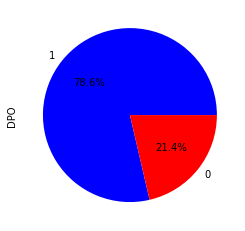

In [138]:
# pd_stats.loc[pd_stats['Country'] != "United States"]["DPO"].value_counts().plot.pie(y='x_value', colors=['blue', 'red'], autopct='%1.1f%%')

# Statistical Analysis (To Do)

### Select potentially interesting predictors

- Employee (object), 
- Type (object), 
- Founded Date (object), 
- Location
- Operating Status (object), 
- Industry 1 (object)
- ...

### Drop old columns

In [230]:
pd_stats.drop(['Founded Date', 'Location'], axis=1, inplace=True)

In [232]:
pd_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 8 to 2788
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Employees      383 non-null    object
 1   Industry 1     425 non-null    object
 2   DPO            425 non-null    int64 
 3   Purpose        425 non-null    int64 
 4   Acquired data  425 non-null    int64 
 5   Data sharing   425 non-null    int64 
 6   Rights         425 non-null    int64 
 7   Founded Year   374 non-null    object
 8   Country        425 non-null    object
dtypes: int64(5), object(4)
memory usage: 49.4+ KB


### Cast to category

In [233]:
# Define the lambda function: categorize_label
label_categorical = lambda x: x.astype('category')

In [234]:
pd_stats = pd_stats.apply(label_categorical, axis=0)

In [237]:
pd_stats.dtypes

Employees        category
Industry 1       category
DPO              category
Purpose          category
Acquired data    category
Data sharing     category
Rights           category
Founded Year     category
Country          category
dtype: object

### LR with Statsmodels

In [236]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scaling
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)

In [240]:
pd_stats.isna().sum()

Employees        42
Industry 1        0
DPO               0
Purpose           0
Acquired data     0
Data sharing      0
Rights            0
Founded Year     51
Country           0
dtype: int64

In [102]:
GDPR_classes

['DPO', 'Purpose', 'Acquired data', 'Data sharing', 'Rights']

#### Explore correlations

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


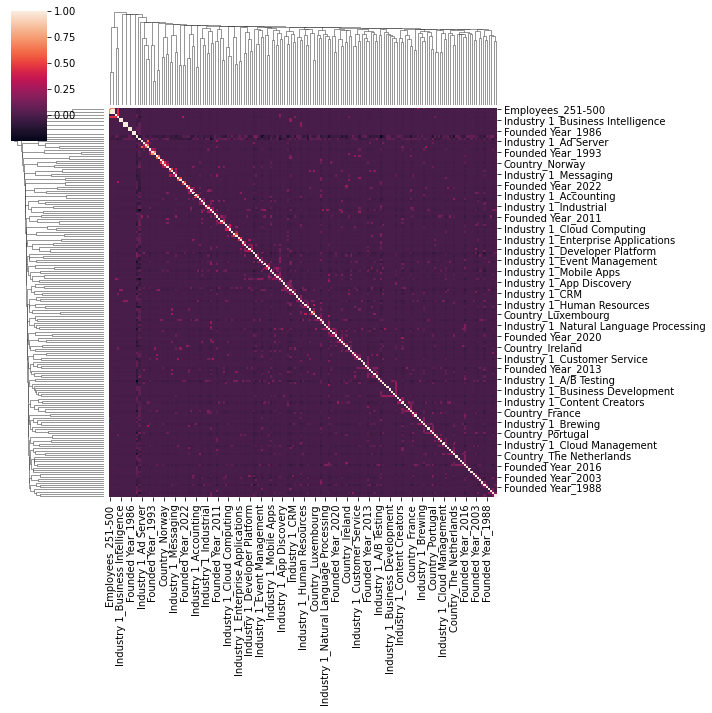

In [247]:
X = pd_stats.drop(GDPR_classes,axis=1) # independant features
X = pd.get_dummies(X, drop_first = True)
sns.clustermap(X.corr())

#### Split data

In [244]:
train, test = train_test_split(pd_stats, test_size=0.2, random_state=42)
X_train = train.drop(GDPR_classes,axis=1) # independant features

#### Encode non-numerical categorical data, and drop first to avoid collinearity

In [245]:
X_train = pd.get_dummies(X_train, drop_first = True)

# Parameter Optimization

#### First without PO

In [288]:
train, test = train_test_split(pd_stats, test_size=0.25, random_state=25)
sel_alpha_list = dict()
acc_last = 0

In [289]:
y_train = train[GDPR_classes[0]] # dependant variable
y_test = test[GDPR_classes[0]] # dependant variable

In [290]:
# independent features
X_train = train.drop(GDPR_classes, axis=1) 
# encode non-numerical categorical data, and drop first to avoid collinearity
X_train = pd.get_dummies(X_train, drop_first = True)

X_test = test.drop(GDPR_classes, axis=1) # independant features
X_test = pd.get_dummies(X_test, drop_first = True)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [294]:
X_train

,const,Employees_101-250,Employees_11-50,Employees_251-500,Employees_51-100,Industry 1_A/B Testing,Industry 1_Accounting,Industry 1_Ad Server,Industry 1_Advertising,Industry 1_Aerospace,Industry 1_Analytics,Industry 1_Android,Industry 1_Animation,Industry 1_App Discovery,Industry 1_Apps,Industry 1_Architecture,Industry 1_Artificial Intelligence,Industry 1_Asset Management,Industry 1_Association,Industry 1_Automotive,Industry 1_B2B,Industry 1_Big Data,Industry 1_Billing,Industry 1_Bitcoin,Industry 1_Blockchain,Industry 1_Brand Marketing,Industry 1_Brewing,Industry 1_Business Development,Industry 1_Business Information Systems,Industry 1_Business Intelligence,Industry 1_CMS,Industry 1_CRM,Industry 1_Charity,Industry 1_Cloud Computing,Industry 1_Cloud Data Services,Industry 1_Cloud Infrastructure,Industry 1_Cloud Management,Industry 1_Collaboration,Industry 1_Communications Infrastructure,Industry 1_Computer,Industry 1_Computer Vision,Industry 1_Consulting,Industry 1_Consumer Software,Industry 1_Content,Industry 1_Content Creators,Industry 1_Creative Agency,Industry 1_Crowdsourcing,Industry 1_Cryptocurrency,Industry 1_Customer Service,Industry 1_Cyber Security,Industry 1_Data Integration,Industry 1_Data Visualization,Industry 1_Database,Industry 1_Desktop Apps,Industry 1_Developer APIs,Industry 1_Developer Platform,Industry 1_Developer Tools,Industry 1_Digital Marketing,Industry 1_Digital Media,Industry 1_Digital Signage,Industry 1_Domain Registrar,Industry 1_E-Commerce,Industry 1_E-Commerce Platforms,Industry 1_E-Learning,Industry 1_EdTech,Industry 1_Education,Industry 1_Employment,Industry 1_Enterprise Applications,Industry 1_Enterprise Resource Planning (ERP),Industry 1_Enterprise Software,Industry 1_Event Management,Industry 1_FinTech,Industry 1_Finance,Industry 1_Financial Services,Industry 1_Food and Beverage,Industry 1_Gambling,Industry 1_Graphic Design,Industry 1_Hardware,Industry 1_Health Care,Industry 1_Human Resources,Industry 1_Industrial,Industry 1_Information Services,Industry 1_Information Technology,Industry 1_Infrastructure,Industry 1_Internet,Industry 1_Internet of Things,Industry 1_Lead Generation,Industry 1_Logistics,Industry 1_Marketing,Industry 1_Media and Entertainment,Industry 1_Messaging,Industry 1_Mobile Apps,Industry 1_Museums and Historical Sites,Industry 1_Natural Language Processing,Industry 1_Network Security,Industry 1_Online Portals,Industry 1_Outsourcing,Industry 1_PaaS,Industry 1_Photo Editing,Industry 1_Podcast,Industry 1_Productivity Tools,Industry 1_SEO,Industry 1_SaaS,Industry 1_Security,Industry 1_Social Media Marketing,Industry 1_Software,Industry 1_Training,Industry 1_UX Design,Industry 1_Web Apps,Founded Year_1986,Founded Year_1987,Founded Year_1988,Founded Year_1990,Founded Year_1993,Founded Year_1995,Founded Year_1996,Founded Year_1997,Founded Year_1998,Founded Year_1999,Founded Year_2000,Founded Year_2001,Founded Year_2002,Founded Year_2003,Founded Year_2004,Founded Year_2005,Founded Year_2006,Founded Year_2007,Founded Year_2008,Founded Year_2009,Founded Year_2010,Founded Year_2011,Founded Year_2012,Founded Year_2013,Founded Year_2014,Founded Year_2015,Founded Year_2016,Founded Year_2017,Founded Year_2018,Founded Year_2019,Founded Year_2020,Founded Year_2021,Founded Year_2022,Country_Austria,Country_Belarus,Country_Belgium,Country_Bosnia and Herzegovina,Country_Bulgaria,Country_Croatia,Country_Cyprus,Country_Czech Republic,Country_Estonia,Country_Finland,Country_France,Country_Germany,Country_Gibraltar,Country_Greece,Country_Hungary,Country_Ireland,Country_Italy,Country_Latvia,Country_Lithuania,Country_Luxembourg,Country_Macedonia,Country_Malta,Country_Moldova,Country_Montenegro,Country_Norway,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Serbia,Country_Slovakia (Slovak Republic),Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_The Netherlands,Country_Turkey,Country_Ukraine,Country_United Kingdom
1390,1.0,0,0,0,0,0,0,0,0,0,

In [287]:
model = sm.Logit(y_train,X_train)
logit_model = model.fit()

C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [ ]:
pred_train = logit_model.predict(X_train)>=.5
pred_test = logit_model.predict(X_test)>=.5

In [ ]:
acc_train = (y_train==pred_train).mean()
acc_test = (y_test==pred_test).mean()

print("Acc: ", acc_test)
print("Alpha: ", alpha_op)

In [279]:
alpha_list = list(np.arange(0.001, 10, 0.1))

##### Optimize parameters

In [282]:
opt_alpha = optimize_logit(pd_stats, True, alpha_list, True)

***************** NEW ROUND!
GDPR-category: Rights
349     1
1608    1
2308    1
2663    1
1778    1
       ..
2527    1
2164    0
1115    0
2166    0
1005    0
Name: Rights, Length: 340, dtype: category
Categories (2, int64): [0, 1]
flag 1
flag 2
Iteration limit reached    (Exit mode 9)
            Current function value: 0.3088550083961797
            Iterations: 1000
            Function evaluations: 1000
            Gradient evaluations: 1000
flag 3
Acc:  0.611764705882353
Alpha:  0.001


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 106 out of 181 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SystemExit: 0

C:\Users\aaberkan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [261]:
X_train

,Employees_101-250,Employees_11-50,Employees_251-500,Employees_51-100,Industry 1_A/B Testing,Industry 1_Accounting,Industry 1_Ad Server,Industry 1_Advertising,Industry 1_Aerospace,Industry 1_Analytics,Industry 1_Android,Industry 1_Animation,Industry 1_App Discovery,Industry 1_Apps,Industry 1_Architecture,Industry 1_Artificial Intelligence,Industry 1_Asset Management,Industry 1_Association,Industry 1_Automotive,Industry 1_B2B,Industry 1_Big Data,Industry 1_Billing,Industry 1_Bitcoin,Industry 1_Blockchain,Industry 1_Brand Marketing,Industry 1_Brewing,Industry 1_Business Development,Industry 1_Business Information Systems,Industry 1_Business Intelligence,Industry 1_CMS,Industry 1_CRM,Industry 1_Charity,Industry 1_Cloud Computing,Industry 1_Cloud Data Services,Industry 1_Cloud Infrastructure,Industry 1_Cloud Management,Industry 1_Collaboration,Industry 1_Communications Infrastructure,Industry 1_Computer,Industry 1_Computer Vision,Industry 1_Consulting,Industry 1_Consumer Software,Industry 1_Content,Industry 1_Content Creators,Industry 1_Creative Agency,Industry 1_Crowdsourcing,Industry 1_Cryptocurrency,Industry 1_Customer Service,Industry 1_Cyber Security,Industry 1_Data Integration,Industry 1_Data Visualization,Industry 1_Database,Industry 1_Desktop Apps,Industry 1_Developer APIs,Industry 1_Developer Platform,Industry 1_Developer Tools,Industry 1_Digital Marketing,Industry 1_Digital Media,Industry 1_Digital Signage,Industry 1_Domain Registrar,Industry 1_E-Commerce,Industry 1_E-Commerce Platforms,Industry 1_E-Learning,Industry 1_EdTech,Industry 1_Education,Industry 1_Employment,Industry 1_Enterprise Applications,Industry 1_Enterprise Resource Planning (ERP),Industry 1_Enterprise Software,Industry 1_Event Management,Industry 1_FinTech,Industry 1_Finance,Industry 1_Financial Services,Industry 1_Food and Beverage,Industry 1_Gambling,Industry 1_Graphic Design,Industry 1_Hardware,Industry 1_Health Care,Industry 1_Human Resources,Industry 1_Industrial,Industry 1_Information Services,Industry 1_Information Technology,Industry 1_Infrastructure,Industry 1_Internet,Industry 1_Internet of Things,Industry 1_Lead Generation,Industry 1_Logistics,Industry 1_Marketing,Industry 1_Media and Entertainment,Industry 1_Messaging,Industry 1_Mobile Apps,Industry 1_Museums and Historical Sites,Industry 1_Natural Language Processing,Industry 1_Network Security,Industry 1_Online Portals,Industry 1_Outsourcing,Industry 1_PaaS,Industry 1_Photo Editing,Industry 1_Podcast,Industry 1_Productivity Tools,Industry 1_SEO,Industry 1_SaaS,Industry 1_Security,Industry 1_Social Media Marketing,Industry 1_Software,Industry 1_Training,Industry 1_UX Design,Industry 1_Web Apps,Founded Year_1986,Founded Year_1987,Founded Year_1988,Founded Year_1990,Founded Year_1993,Founded Year_1995,Founded Year_1996,Founded Year_1997,Founded Year_1998,Founded Year_1999,Founded Year_2000,Founded Year_2001,Founded Year_2002,Founded Year_2003,Founded Year_2004,Founded Year_2005,Founded Year_2006,Founded Year_2007,Founded Year_2008,Founded Year_2009,Founded Year_2010,Founded Year_2011,Founded Year_2012,Founded Year_2013,Founded Year_2014,Founded Year_2015,Founded Year_2016,Founded Year_2017,Founded Year_2018,Founded Year_2019,Founded Year_2020,Founded Year_2021,Founded Year_2022,Country_Austria,Country_Belarus,Country_Belgium,Country_Bosnia and Herzegovina,Country_Bulgaria,Country_Croatia,Country_Cyprus,Country_Czech Republic,Country_Estonia,Country_Finland,Country_France,Country_Germany,Country_Gibraltar,Country_Greece,Country_Hungary,Country_Ireland,Country_Italy,Country_Latvia,Country_Lithuania,Country_Luxembourg,Country_Macedonia,Country_Malta,Country_Moldova,Country_Montenegro,Country_Norway,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Serbia,Country_Slovakia (Slovak Republic),Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_The Netherlands,Country_Turkey,Country_Ukraine,Country_United Kingdom
141,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

In [267]:
y_train

NameError: name 'y_train' is not defined

In [281]:
def optimize_logit(pd_stats, reg, alpha_range, intercept_set):
    train, test = train_test_split(pd_stats, test_size=0.2, random_state=25)
    sel_alpha_list = dict()
    acc_last = 0

    for GDPR_cat in GDPR_classes:
        alpha_sel = alpha_range[0]
        acc_last = 0

        print("***************** NEW ROUND!")
        for alpha_op in alpha_range:
            print("GDPR-category: " + GDPR_class)

            y_train = train[GDPR_class] # dependant variable
            y_test = test[GDPR_class] # dependant variable
            
#             sys.exit(0)

            # independent features
            X_train = train.drop(GDPR_classes, axis=1) 
            # encode non-numerical categorical data, and drop first to avoid collinearity
            X_train = pd.get_dummies(X_train, drop_first = True)

            X_test = test.drop(GDPR_classes, axis=1) # independant features
            X_test = pd.get_dummies(X_test, drop_first = True)

            if(intercept_set):
                X_train = sm.add_constant(X_train)
                X_test = sm.add_constant(X_test)
                
            print(y_train)

            print("flag 1")
            model = sm.Logit(y_train,X_train)
            print("flag 2")

            if(reg):
                logit_model = model.fit_regularized(method = 'l1', trim_mode = 'size', alpha = alpha_op)
            else:
                logit_model = model.fit()

            print("flag 3")

            pred_train = logit_model.predict(X_train)>=.5

            pred_test = logit_model.predict(X_test)>=.5

            acc_train = (y_train==pred_train).mean()

            acc_test = (y_test==pred_test).mean()
            
            print("Acc: ", acc_test)
            print("Alpha: ", alpha_op)

            sys.exit(0)
            if(acc_test >= acc_last):
                print("Alpha selected!")
                alpha_sel = alpha_op 
                acc_last = acc_test

            # last alpha in range? Place optimized alpha and accuracy in dict
            if(alpha_op == alpha_list[-1]):
                sel_alpha_list[GDPR_class] = [alpha_sel, acc_last]
            
            print()
            print()

    return sel_alpha_list